<a href="https://colab.research.google.com/github/mfares07/Teledeteccion_BsAs_Australia/blob/main/Teledetecci%C3%B3n_Bs_As_Australia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Necesario instalar librerías para la generación de mapas (demora un poco)
!pip install --upgrade geemap --progress-bar on -q
!pip install --upgrade folium --progress-bar on -q

In [36]:
# Importamos las librerías necesarias
import geemap
import ee
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

from IPython.display import Image, display, clear_output, HTML
import ipywidgets as widgets
import folium
import json
import requests

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Conectamos con Earth Engine

In [37]:
# URL del archivo JSON para obtener las credenciales para Earth Engine
url = "https://drive.google.com/uc?id=10WaATQLa6qKDKPUIcN-W4jG7d2Bc2uG-"

# Descargar el contenido del archivo JSON
response = requests.get(url)
credentials = json.loads(response.content)

# Función para inicializar Earth Engine
def initialize_ee():
    try:
        service_account = credentials['client_email']
        private_key = credentials['private_key']

        credentials_ee = ee.ServiceAccountCredentials(service_account, key_data=private_key)
        ee.Initialize(credentials_ee)
        print("Earth Engine inicializado correctamente.")
    except Exception as e:
        print(f"Error al inicializar Earth Engine: {str(e)}")

# Inicializar Earth Engine
initialize_ee()

Earth Engine inicializado correctamente.


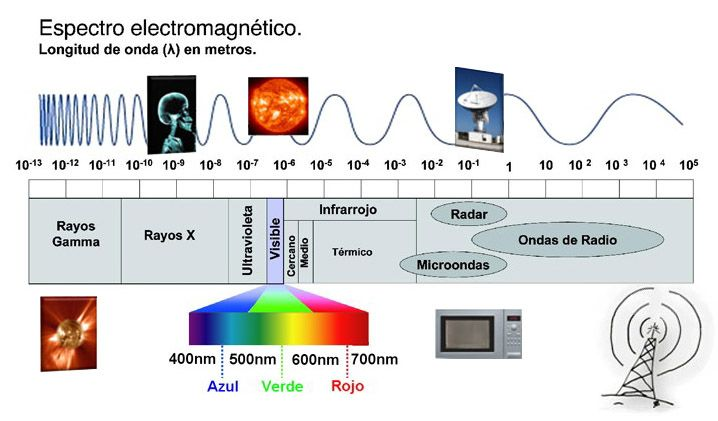

In [38]:
# Enlace directo a la imagen
url_espectro = 'https://i.pinimg.com/originals/6b/96/d1/6b96d17d8d09bc5929710ea0513026fa.jpg'
# Mostramos la imagen en Google Colab
Image(url_espectro)

# Cálculo del NDVI



NDVI=(NIR−Red) / (NIR+Red)
​
<br>

Donde:   

NIR es la reflectancia en el infrarrojo cercano.  
Red es la reflectancia en el espectro visible rojo.

<br>

 *Valores cercanos a 1 indican vegetación densa y saludable.
Valores cercanos a 0 indican poca o ninguna vegetación.
Valores negativos indican superficies como agua, nieve, nubes o suelos desnudos.*

## Cálculo del EVI

EVI = ​G * (NIR−Red) / (NIR+C1×Red−C2×Blue+L)

<br>
Donde:
<br>
NIR es la reflectancia en el infrarrojo cercano.<br>
Red es la reflectancia en el espectro visible rojo.<br>
Blue es la reflectancia en el espectro visible azul.<br>
G es un factor de ganancia (generalmente G = 2.5).<br>
C1 y C2 son coeficientes para la corrección atmosférica (C1 = 6, C2 = 7.5).<br>
L es un término de corrección de fondo del suelo (L = 1).


In [39]:
# Calcula el Índice de Vegetación de Diferencia Normalizada (NDVI)
def get_nvdi(image):

  nvdi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
  image = image.addBands(nvdi)

  return image


# Calcula el Índice de Vegetación mejorado (EVI)
def get_evi(image):

  evi = image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
                         {'NIR':  image.select('B5').divide(10000),
                          'RED':  image.select('B4').divide(10000),
                          'BLUE': image.select('B2').divide(10000)
                          }).rename('EVI')
  image = image.addBands(evi)

  return image

In [40]:
def add_date(image):
    # Obtener la fecha como objeto ee.Date
    img_date = ee.Date(image.date())

    # Obtener año, mes y día como números
    year = img_date.get('year')
    month = img_date.get('month')
    day = img_date.get('day')

    # Construir el número YYYYMMDD como un número entero
    img_date_number = ee.Number(year).multiply(10000).add(ee.Number(month).multiply(100)).add(day)

    # Añadir la fecha como una banda a la imagen
    image = image.addBands(ee.Image(img_date_number).rename('date').toInt())

    return image

In [41]:
# Extrae la información de los píxeles
def raster_extract(image, fc):
  feature = image.sampleRegions(
      collection = fc,
      scale = 30
  )
  return feature

Creación del Data Frame

In [42]:
# Especificar la ruta al archivo csv
path_samples = r"https://drive.google.com/uc?export=download&id=1gHjTfq7uvTtEfCdvsCwGTLgMsA8KSMQu"

# Leer el archivo de Excel en un DataFrame de pandas
df = pd.read_csv(path_samples)

# Mostrar el DataFrame
df.head()

,target,longitude,latitude
0,0,-58.434852,-34.555612
1,0,-58.434509,-34.555709
2,0,-58.433918,-34.556991
3,0,-58.433436,-34.557220
4,0,-58.433157,-34.557715


In [43]:
# Definimos puntos y un polígono
Bs_As_point = ee.Geometry.Point([df.longitude.mean(), df.latitude.mean()])

# El condicional selecciona el polígono situado en Palermo o en CABA
if df.longitude.mean() < -58.43:
  poligon_BsAs = ee.Geometry.Polygon([
        # Palermo
        [-58.448,-34.562],
        [-58.426,-34.562],
        [-58.426,-34.548],
        [-58.448,-34.548],
        [-58.448,-34.562],
  ])

else:
  poligon_BsAs = ee.Geometry.Polygon([
        # CABA
        [-58.381, -34.614],
        [-58.345, -34.613],
        [-58.348, -34.596],
        [-58.383, -34.597],
        [-58.381, -34.614]
  ])

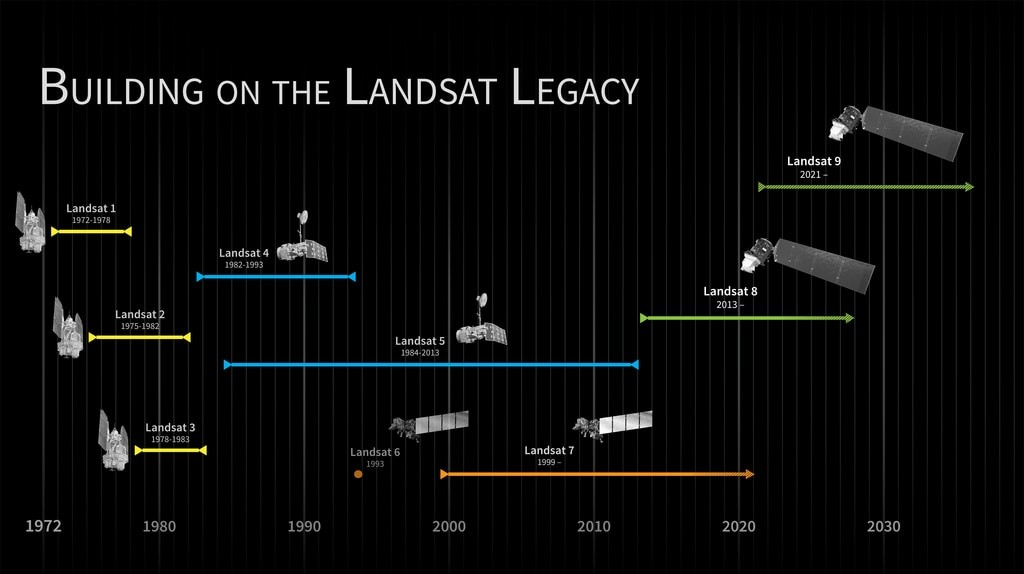

In [44]:
# Enlace directo a la imagen
url = "https://appliedsciences.nasa.gov/sites/default/files/landsat-timeline.jpg"
Image(url)

In [45]:
# Obtenemos una colección de imágenes del satélite Landsat 9

landsat_data = ee.ImageCollection("LANDSAT/LC09/C02/T1_TOA")\
    .filterDate('2023-01-01', '2024-12-20')\
    .filterBounds(Bs_As_point)\
    .filter(ee.Filter.lt('CLOUD_COVER', 15))\
    .sort('CLOUD_COVER')\
    .map(get_nvdi).map(get_evi).map(add_date)

In [46]:
# Obtenemos la primera imagen de la colección
first_image = landsat_data.first()

# Imprimimos las bandas de la imagen para verificar
print("Bandas de la imagen Landsat:", first_image.bandNames().getInfo())

Bandas de la imagen Landsat: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'QA_PIXEL', 'QA_RADSAT', 'SAA', 'SZA', 'VAA', 'VZA', 'NDVI', 'EVI', 'date']


In [47]:
# Esta función obtiene el tamaño de la colección y lo convierte a un valor de Python
def collectionSize(collection):
  return collection.size().getInfo()

# Imprimimos el tamaño de la colección
collection_size = collectionSize(landsat_data)
print('Cantidad de imágenes de la colección: ', collection_size)

Cantidad de imágenes de la colección:  11


In [48]:
# Con esta función creamos las features Collection (puntos geometricos y propiedades)
def features_create(df):

  features = []
  for index, row in df.iterrows():

    poi_geometry = ee.Geometry.Point(row['longitude'], row['latitude'])
    poi_properties = dict(row)

    poi_feature = ee.Feature(poi_geometry, poi_properties)
    features.append(poi_feature)

  ee_fc = ee.FeatureCollection(features)

  return ee_fc


In [49]:
# Creamos un objeto de tipo Feature Collection
ee_fc = features_create(df)

In [50]:
# Acá podemos limitar la cantidad de imágenes y obtener solo una.
landsat_data = landsat_data.limit(collection_size)
img_list = landsat_data.toList(landsat_data.size())

image = ee.Image(img_list.get(0))

In [51]:
# Definimos los parámetros de visualización
viz_params = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.3,
  'gamma': 0.75
}

target_colors = {
    0: 'blue',  # Agua
    1: 'red',   # Urbano
    2: 'green'  # Vegetación
}

# Obtenemos la fecha de la imagen
print('Fecha de la imagen:', image.get('DATE_ACQUIRED').getInfo())

# Centramos el mapa en Buenos Aires
m = geemap.Map(
    center=[Bs_As_point.getInfo()['coordinates'][1],
            Bs_As_point.getInfo()['coordinates'][0]], zoom=8)

# Seteamos el tipo de mapa:
m.add_basemap('SATELLITE')

# Añadimos la imagen al mapa
m.addLayer(image, viz_params, 'Landsat 9')

# Convertimos el polígono en una Feature
polygon_feature = ee.Feature(poligon_BsAs, {'name': 'Buenos Aires Polygon'})

# Añadimos el polígono de Buenos Aires al mapa
m.addLayer(polygon_feature, {'color': 'd6a62e'}, 'Buenos Aires Polygon')

# Añadimos los puntos filtrados al mapa con los colores correspondientes
for key, color in target_colors.items():
    filt_fc = ee_fc.filter(ee.Filter.eq('target', key))
    m.addLayer(filt_fc.style(**{'color': color}), {}, f'targets ({key})')


# Mostrar el mapa interactivo
display(m)

Fecha de la imagen: 2023-10-01


Map(center=[-34.557168354071656, -58.43732455359537], controls=(WidgetControl(options=['position', 'transparen…

In [53]:
# Seleccionamos las bandas de interés
bands = ['date', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11','NDVI', 'EVI']

# Filtramos por POI, extraemos pixeles y aplanamos todo en un FeatureCollection
results = landsat_data\
    .select(bands)\
    .map(lambda image: raster_extract(image, ee_fc))\
    .flatten()

sample_results = results.first().getInfo()

In [54]:
# Listamos las propiedades del featureCollection
columns = list(sample_results['properties'])
print(f'Propiedades del featureCollection: {columns}')

# Extendemos los nombres de los campos para que coincidan
columns_df = list(df.columns)
columns_df.extend(bands)
print(f'Columnas del dataFrame: {columns_df}')

Propiedades del featureCollection: ['B1', 'B10', 'B11', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'EVI', 'NDVI', 'date', 'latitude', 'longitude', 'target']
Columnas del dataFrame: ['target', 'longitude', 'latitude', 'date', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'NDVI', 'EVI']


In [55]:
# Creamos las columnas necesarias para crear el dataFrame
final_list = results.reduceColumns(ee.Reducer.toList(len(columns_df)), columns_df).values().get(0)
data = final_list.getInfo()

In [56]:
# Creamos el dataFrame
df_ = pd.DataFrame(data, columns = columns_df)
df_.head(12)

,target,longitude,latitude,date,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,NDVI,EVI
0,0,-58.434852,-34.555612,20231001,0.123311,0.102598,0.081750,0.060795,0.057782,0.052779,0.039463,0.058132,0.001399,292.938812,293.088898,-0.025408,-7.532370e-07
1,0,-58.434509,-34.555709,20231001,0.116210,0.094044,0.068515,0.041346,0.020982,0.011944,0.008151,0.057244,0.001211,292.022247,291.964691,-0.326716,-5.091123e-06
2,0,-58.433918,-34.556991,20231001,0.116237,0.092833,0.064453,0.037849,0.019288,0.008716,0.004896,0.054796,0.001399,291.565338,291.332825,-0.324859,-4.640529e-06
3,0,-58.433436,-34.557220,20231001,0.115968,0.092484,0.064803,0.037338,0.017969,0.007398,0.005703,0.055146,0.001453,291.471466,291.265167,-0.350195,-4.842291e-06
4,0,-58.433157,-34.557715,20231001,0.115457,0.092349,0.064265,0.037634,0.011782,0.008043,0.005864,0.053693,0.001157,291.505615,291.421967,-0.523136,-6.463115e-06
5,0,-58.432481,-34.558157,20231001,0.115214,0.090950,0.061871,0.035724,0.017996,0.006967,0.005488,0.052536,0.001049,291.303406,291.037323,-0.329995,-4.432041e-06
6,0,-58.432030,-34.558855,20231001,0.115752,0.092457,0.062005,0.037472,0.017943,0.010841,0.007102,0.051514,0.001587,291.169373,290.960266,-0.352427,-4.882643e-06
7,0,-58.431301,-34.559456,20231001,0.114999,0.091999,0.062301,0.037096,0.011352,0.006967,0.005407,0.052187,0.001345,291.562500,291.179016,-0.531371,-6.436215e-06
8,0,-58.430356,-34.559915,20231001,0.116640,0.093882,0.066848,0.039920,0.016813,0.006671,0.005246,0.056652,0.001184,291.160797,290.975677,-0.407302,-5.777120e-06
9,0,-58.429852,-34.560110,20231001,0.117743,0.095550,0.070291,0.043094,0.017620,0.006806,0.005703,0.059826,0.001237,291.784088,291.458832,-0.419583,-6.368951e-06


In [57]:
# Habrá {cantidad de imágenes} * {cantidad de puntos}
print('Habrá {} filas ({} Imágenes * {} puntos) '.format(df.shape[0] * landsat_data.size().getInfo(), landsat_data.size().getInfo(), df.shape[0] ))
print(f'Lo comprobamos con un shape: {df_.shape}')

Habrá 1650 filas (11 Imágenes * 150 puntos) 
Lo comprobamos con un shape: (1650, 17)


In [58]:
# Vemos un resumen estadístico
df_.describe()

,target,longitude,latitude,date,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,NDVI,EVI
count,1650.000000,1650.000000,1650.000000,1.650000e+03,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000
mean,1.000000,-58.437325,-34.557168,2.023326e+07,0.143771,0.124271,0.108086,0.095157,0.198863,0.153132,0.105364,0.107044,0.001290,294.150907,293.095196,0.201544,0.000026
std,0.816744,0.005144,0.002455,4.315435e+03,0.032079,0.037687,0.043287,0.057849,0.136203,0.117188,0.099641,0.068305,0.000458,5.365097,4.867149,0.351308,0.000029
min,0.000000,-58.446661,-34.561232,2.023010e+07,0.108021,0.084656,0.053436,0.034594,0.011352,0.003474,0.002412,0.045803,0.000182,276.881866,276.882599,-0.531371,-0.000008
25%,0.000000,-58.442471,-34.559323,2.023041e+07,0.119546,0.096765,0.074431,0.046871,0.040106,0.019977,0.014257,0.063059,0.000983,292.853119,291.911133,-0.075993,-0.000002
50%,1.000000,-58.436232,-34.557318,2.023100e+07,0.134039,0.112822,0.100452,0.081647,0.211807,0.173135,0.105598,0.086621,0.001212,295.629150,294.543060,0.210808,0.000017
75%,2.000000,-58.433069,-34.555612,2.024022e+07,0.158291,0.139461,0.127190,0.125451,0.301018,0.233214,0.155821,0.125553,0.001506,297.491623,296.160995,0.550594,0.000050
max,2.000000,-58.429288,-34.550328,2.024032e+07,0.360010,0.415655,0.424447,0.581901,0.776633,1.041881,1.312461,0.822669,0.004155,302.828644,301.408905,0.746642,0.000103


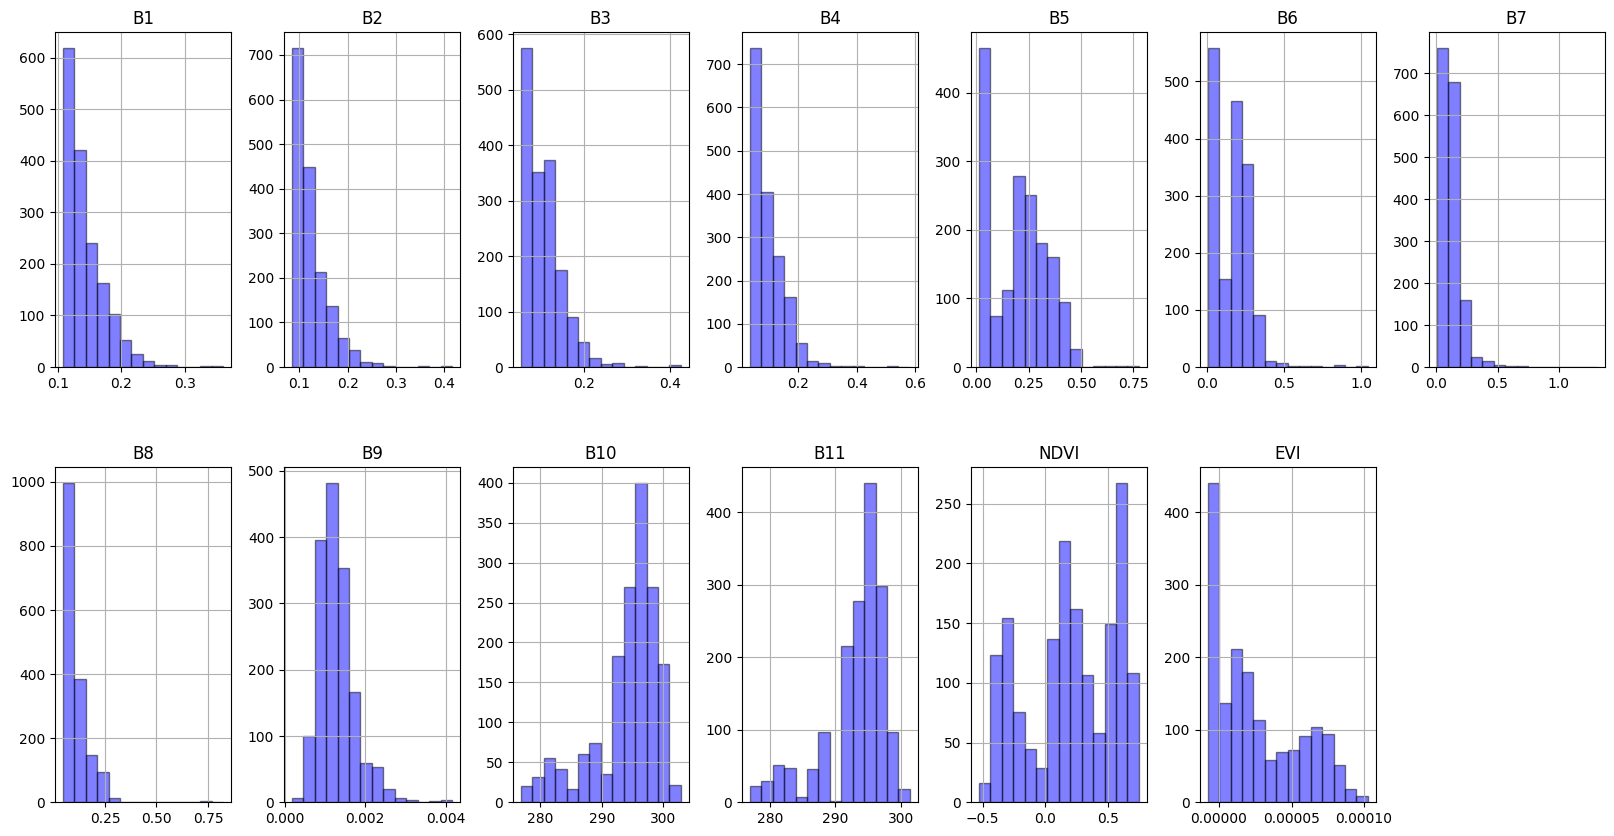

In [59]:
# Creamos el histograma con los datos de df_.iloc[:, 4:]
df_.iloc[:, 4:].hist(grid=True, bins=14, figsize=(20, 10), layout=(2,7), edgecolor='black', color='blue', alpha=0.5)

# Mostramos el histograma
plt.show()

In [60]:
# Vemos cuantos puntos geográfico por fecha habrá
df_['date'].value_counts()

date
20231001    150
20230102    150
20231118    150
20230408    150
20230611    150
20230219    150
20230510    150
20231017    150
20240325    150
20240309    150
20240222    150
Name: count, dtype: int64

# Creación del modelo de Machine Learning usando el algoritmo de Random Forest

In [61]:
# Dividimos en grupo de entrenamiento y testeo

y = df_['target']
X = df_.drop(['target', 'longitude', 'latitude', 'date'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.45, stratify=y, random_state=0)

In [62]:
# Creamos el pipeline con StandardScaler y RandomForestClassifier
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=0))

In [63]:
# Combinamos los hiperparámetros
param_grid = {
    'randomforestclassifier__n_estimators': [100, 150, 175],
    'randomforestclassifier__min_samples_split': [2, 3, 4],
    'randomforestclassifier__min_samples_leaf': [1, 2]
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__min_samples_leaf': [1, 2],
                         'randomforestclassifier__min_samples_split': [2, 3, 4],
                         'randomforestclassifier__n_estimators': [100, 150,
                                                                  175]},
             scoring='accuracy')

In [64]:
# Vemos la mejor puntuación y los mejores parámetros
print(f'Mejor accuracy: {gs.best_score_ * 100} %')
print(f'Mejores parámetros: {gs.best_params_}')

Mejor accuracy: 98.45546718474895 %
Mejores parámetros: {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}


In [65]:
# Nos quedamos con el mejor estimador
rf_best = gs.best_estimator_
print('Test accuracy: %.3f %%' % (rf_best.score(X_test, y_test)* 100))

Test accuracy: 98.385 %


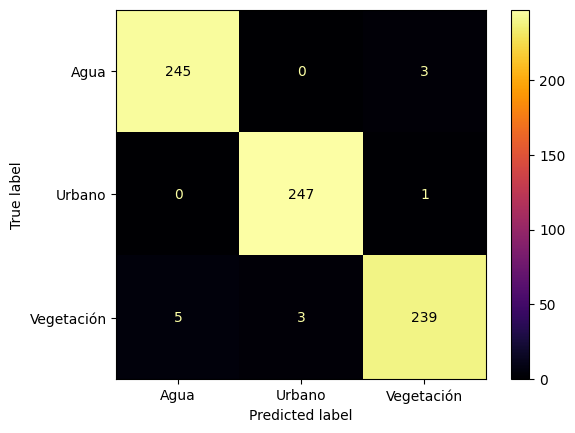

In [66]:
# Vemos la matriz de confusión
y_pred_cm = rf_best.predict(X_test)

# Ahora la graficamos
conf = confusion_matrix(y_test, y_pred_cm)
labels = ['Agua', 'Urbano', 'Vegetación']
ConfusionMatrixDisplay(conf, display_labels=labels).plot(cmap='inferno')

In [67]:
# Creamos el DataFrame
df_errors = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_cm})

# Filtramos manualmente las discrepancias
errores = df_errors[df_errors['y_pred'] != df_errors['y_test']]

# Obtenemos los índices de errores como una lista
indices_errores = errores.index.tolist()

# Mostramos las filas correspondientes en df_
filas_errores = df_.loc[indices_errores, ['longitude', 'latitude', 'date']]

# Agregamos las columnas 'y_test' y 'y_pred' al DataFrame filas_errores
filas_errores = filas_errores.join(errores[['y_test', 'y_pred']])

# Mostramos las filas y las columnas deseadas de X_test
filas_errores

,longitude,latitude,date,y_test,y_pred
1301,-58.438830,-34.557521,20240325,2,0
249,-58.443115,-34.556456,20230102,1,2
1020,-58.437025,-34.554994,20230510,2,0
731,-58.437239,-34.561232,20230611,2,1
173,-58.433590,-34.558196,20230102,0,2
873,-58.436510,-34.550328,20230219,2,1
1309,-58.436491,-34.558935,20240325,2,0
1333,-58.436016,-34.560013,20240325,2,0
720,-58.437025,-34.554994,20230611,2,0
323,-58.433590,-34.558196,20231118,0,2


In [68]:
# Definimos subcapas
layer_sa = folium.FeatureGroup(name="map_Satellite")
layer_roa = folium.FeatureGroup(name="map_Roadmap")
layer_poi = folium.FeatureGroup(name="map_Points")

# Centrar el mapa en Buenos Aires
m_err = folium.Map(
    location=[Bs_As_point.getInfo()['coordinates'][1],
              Bs_As_point.getInfo()['coordinates'][0]],
    zoom_start=15, tiles=None)

folium.TileLayer('Esri_WorldImagery').add_to(layer_sa)

# Capa tipo RoadMap
folium.TileLayer('OpenStreetMap').add_to(layer_roa)


for index, row in filas_errores.iterrows():
  # Más íconos aca: https://fontawesome.com/icons y reemplazar 'location-dot'
    kw = {"prefix": "fa", "icon": "location-dot", 'shadow_anchor': (10, 12)}
    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup=tuple((row['longitude'], row['latitude'])),
                  icon=folium.Icon(color=target_colors[row['y_pred']], **kw)
                  ).add_to(layer_poi)

layer_roa.add_to(m_err)
layer_sa.add_to(m_err)
layer_poi.add_to(m_err)
folium.LayerControl(position='topleft').add_to(m_err)

# Mostramos el mapa interactivo
display(m_err)

# Realizamos una predicción sobre una zona de Australia

In [69]:
# Especificamos la ruta al archivo csv que contiene los puntos en Australia
path_aus_points = r"https://drive.google.com/uc?export=download&id=1NjwwWBshz4P7-YUzxX4mdK-tEwu7ZNF8"

# Leemos el archivo csv y crear un DataFrame de pandas
df_au = pd.read_csv(path_aus_points)

# Mostramos el DataFrame
df_au.head(10)

,target,longitude,latitude
0,0,115.827247,-31.928686
1,0,115.825724,-31.926756
2,0,115.825323,-31.927911
3,0,115.825409,-31.929259
4,0,115.829701,-31.929077
5,0,115.830731,-31.930533
6,0,115.830130,-31.931517
7,0,115.825581,-31.932354
8,0,115.825366,-31.930388
9,0,115.827469,-31.931007


In [70]:
# Creamos una colección con respecto a Australia
ee_fc_Aus = features_create(df_au)

In [71]:
# Definimos puntos
Australia_point = ee.Geometry.Point([df_au.longitude.mean(), df_au.latitude.mean()])

In [72]:
# Obtenemos las imágenes satelitales para Australia
landsat_australia = ee.ImageCollection("LANDSAT/LC09/C02/T1_TOA")\
    .filterDate('2024-01-01', '2024-12-20')\
    .filterBounds(Australia_point)\
    .filter(ee.Filter.lt('CLOUD_COVER', 10))\
    .sort('CLOUD_COVER')\
    .map(get_nvdi).map(get_evi).map(add_date)

In [73]:
# Obtenemos la primera imagen de la colección
first_img_aus = landsat_australia.first()

# Imprimimos las bandas de la imagen para verificar
print("Bandas de la imagen Landsat:", first_img_aus.bandNames().getInfo())

Bandas de la imagen Landsat: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'QA_PIXEL', 'QA_RADSAT', 'SAA', 'SZA', 'VAA', 'VZA', 'NDVI', 'EVI', 'date']


In [74]:
# Imprimimos el tamaño de la colección
size_australia = collectionSize(landsat_australia)
print('Cantidad de imágenes de la colección: ', size_australia)

Cantidad de imágenes de la colección:  10


In [76]:
# Utilizamos Folium para crear el mapa
m_aus = folium.Map(
    location=[Australia_point.getInfo()['coordinates'][1],
              Australia_point.getInfo()['coordinates'][0]],
    zoom_start=15,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)

# Iteramos sobre el DataFrame para añadir los marcadores
for index, row in df_au.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup=row['target'],
                  icon=folium.Icon(color='orange', **kw)
                  ).add_to(m_aus)

# Mostramos el mapa interactivo
display(m_aus)

In [78]:
# Filtramos por POI, extraemos pixeles y aplanamos todo en un FeatureCollection
results_au = landsat_australia\
    .select(bands)\
    .map(lambda image: raster_extract(image, ee_fc_Aus))\
    .flatten()

sample_results_au = results_au.first().getInfo()

In [79]:
# listamos las propiedades del featureCollection
columns_au = list(sample_results_au['properties'])
print(f'Propiedades del featureCollection: {columns_au}')

# Extendemos los campos para que coincidan
columns_df_au = list(df_au.columns)
columns_df_au.extend(bands)
print(f'Columnas del dataFrame: {columns_df_au}')

Propiedades del featureCollection: ['B1', 'B10', 'B11', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'EVI', 'NDVI', 'date', 'latitude', 'longitude', 'target']
Columnas del dataFrame: ['target', 'longitude', 'latitude', 'date', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'NDVI', 'EVI']


In [80]:
# Creamos el DataFrame
final_list_au = results_au.reduceColumns(ee.Reducer.toList(len(columns_df_au)), columns_df_au).values().get(0)
data_au = final_list_au.getInfo()
df_aus = pd.DataFrame(data_au, columns = columns_df_au)
print(df_aus.shape)
df_aus.head(12)

(450, 17)


,target,longitude,latitude,date,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,NDVI,EVI
0,0,115.827247,-31.928686,20240130,0.118478,0.097735,0.104033,0.064467,0.048977,0.006931,0.004547,0.083022,0.001921,296.651489,296.245453,-0.136549,-0.000004
1,0,115.825724,-31.926756,20240130,0.118624,0.097321,0.102914,0.063397,0.049220,0.008049,0.005569,0.083095,0.001702,296.895844,296.514801,-0.125891,-0.000004
2,0,115.825323,-31.927911,20240130,0.119208,0.097978,0.103206,0.063835,0.049317,0.008365,0.005861,0.083241,0.001800,296.985291,296.653687,-0.128304,-0.000004
3,0,115.825409,-31.929259,20240130,0.118381,0.097662,0.103012,0.064370,0.050387,0.008341,0.005472,0.081612,0.002091,297.050323,296.665497,-0.121848,-0.000003
4,0,115.829701,-31.929077,20240130,0.118138,0.097102,0.102671,0.062400,0.047882,0.006615,0.004547,0.082244,0.001848,296.836151,296.467468,-0.131643,-0.000004
5,0,115.830731,-31.930533,20240130,0.118186,0.097394,0.106659,0.064686,0.049487,0.007368,0.004961,0.084238,0.001678,296.950073,296.494080,-0.133120,-0.000004
6,0,115.830130,-31.931517,20240130,0.117992,0.096981,0.101139,0.062230,0.048150,0.007174,0.004766,0.081101,0.001775,297.015106,296.585724,-0.127561,-0.000004
7,0,115.825581,-31.932354,20240130,0.118964,0.098051,0.101066,0.063252,0.052138,0.009679,0.006858,0.082439,0.001921,297.520599,297.328430,-0.096312,-0.000003
8,0,115.825366,-31.930388,20240130,0.119062,0.097832,0.102258,0.063884,0.050728,0.008049,0.005569,0.081685,0.002091,297.088226,296.695038,-0.114789,-0.000003
9,0,115.827469,-31.931007,20240130,0.118405,0.097248,0.096349,0.060893,0.048758,0.007466,0.005155,0.078013,0.001556,296.933807,296.467468,-0.110668,-0.000003


Predicciones del modelo

In [81]:
# Separamos las características de la variable
X_aus = df_aus.drop(['target', 'date', 'latitude', 'longitude'], axis=1)
y_aus = df_aus['target']

In [82]:
# Vemos la precisión que obtuvo el modelo en los nuevos puntos
print('Test accuracy: %.3f %%' % (rf_best.score(X_aus, y_aus)* 100))

Test accuracy: 96.889 %


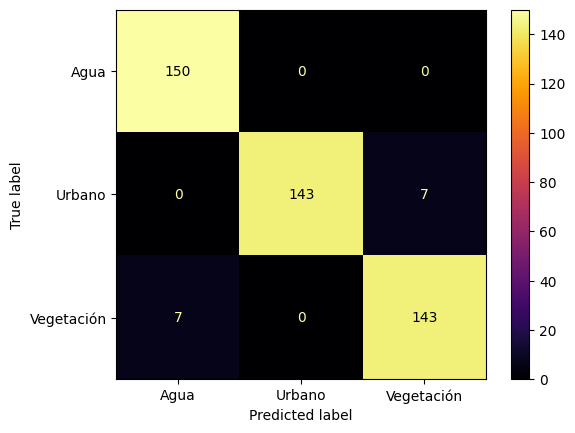

In [83]:
# Vemos la matriz de confusión
y_pred_aus=rf_best.predict(X_aus)

# La visualizamos
conf_au = confusion_matrix(y_aus, y_pred_aus)
labels = ['Agua', 'Urbano', 'Vegetación']
ConfusionMatrixDisplay(conf_au, display_labels=labels).plot(cmap='inferno')

In [85]:
# Creamos el DataFrame
df_errors_au = pd.DataFrame({'y_test_au': y_aus, 'y_pred_au': y_pred_aus})

#Filtramos manualmente las discrepancias
errores_au = df_errors_au[df_errors_au['y_pred_au'] != df_errors_au['y_test_au']]

#Obtenemos los índices de errores como una lista
indices_errores_au = errores_au.index.tolist()

#Mostramos las filas correspondientes en X_aus
filas_errores_au = df_aus.loc[indices_errores_au, ['longitude', 'latitude', 'date']]

# Agregamos las columnas 'y_test_au' y 'y_pred_au' al DataFrame filas_errores_au
filas_errores_au = filas_errores_au.join(errores_au[['y_test_au', 'y_pred_au']])

In [86]:
# Utilizamos Folium para crear el mapa
m_err_au = folium.Map(location=[-31.925, 115.82], zoom_start=15, tiles=None)

# Definimos subcapas
layer_sat = folium.FeatureGroup(name="map_Satellite")
layer_road = folium.FeatureGroup(name="map_Roadmap")
layer_points = folium.FeatureGroup(name="map_Points")

# Agregamos los mapas como capas

folium.TileLayer('Esri_WorldImagery').add_to(layer_sat)
folium.TileLayer('OpenStreetMap').add_to(layer_road)

# Iteramos sobre el DataFrame para añadir los marcadores
for index, row in filas_errores_au.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup=row['y_pred_au'],
                  icon=folium.Icon(
                      color=target_colors[row['y_pred_au']],
                      shadow_size=(15, 34), **kw)
                  ).add_to(layer_points)

# Agregamos las capas y el control
layer_road.add_to(m_err_au)
layer_sat.add_to(m_err_au)
layer_points.add_to(m_err_au)

folium.LayerControl(position='topleft').add_to(m_err_au)

# Mostramos el mapa interactivo
display(m_err_au)

# Reporte final en términos de negocio
Este reporte evalúa el rendimiento financiero del modelo Random Forest en la clasificación de "agua", "zona urbana" y "vegetación", calculando la ganancia neta esperada, pérdida esperada y beneficio esperado basados en precisión, recall y montos configurables.

In [87]:
# Generamos un reporte con las métricas obtenidas
reporte_clasificacion = classification_report(y_aus, y_pred_aus, output_dict=False)
print(reporte_clasificacion)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       150
           1       1.00      0.95      0.98       150
           2       0.95      0.95      0.95       150

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



In [88]:
# Extraemos y redondeamos los valores de precisión y recall

reporte_clasificacion = classification_report(y_aus, y_pred_aus, output_dict=True)

precision_agua = round(float(reporte_clasificacion['0']['precision']), 3)
precision_urbana = round(float(reporte_clasificacion['1']['precision']), 3)
precision_vegetacion = round(float(reporte_clasificacion['2']['precision']), 3)

recall_agua = round(float(reporte_clasificacion['0']['recall']), 3)
recall_urbana = round(float(reporte_clasificacion['1']['recall']), 3)
recall_vegetacion = round(float(reporte_clasificacion['2']['recall']), 3)

support_agua = reporte_clasificacion['0']['support']
support_urbana = reporte_clasificacion['1']['support']
support_vegetacion = reporte_clasificacion['2']['support']


Creamos los widgets configurables por el usuario

In [89]:
# Definimos los sliders con valores iniciales
min_gain = 0
max_gain = 50
min_loss = 50
max_loss = 500
value_gain = (min_gain + max_gain) // 2
value_loss = (min_loss + max_loss) // 2

# Función para crear sliders
def create_slider(value, min_val, max_val, description, handle_color, margin='0 48px 0 16px'):
    return widgets.FloatSlider(
        value=value,
        min=min_val,
        max=max_val,
        step=1,
        description=description,
        orientation='vertical',
        style={'handle_color': handle_color},
        layout=widgets.Layout(margin=margin)
    )

# Creamos los sliders usando la función
water_gain = create_slider(value_gain, min_gain, max_gain, 'Ganancia agua', 'green')
water_loss = create_slider(value_loss, min_loss, max_loss, 'Pérdida agua', 'red')
urban_gain = create_slider(value_gain, min_gain, max_gain, 'Ganancia urbana', 'green')
urban_loss = create_slider(value_loss, min_loss, max_loss, 'Pérdida urbana', 'red')
vegetation_gain = create_slider(value_gain, min_gain, max_gain, 'Ganancia vegetación', 'green')
vegetation_loss = create_slider(value_loss, min_loss, max_loss, 'Pérdida vegetación', 'red')

# Mostramos los sliders
output = widgets.Output()

In [90]:
# Función para calcular el rendimiento esperado
def calculate_gain(gA, pA, gU, pU, gV, pV):

  ganancia_neta_esperada = (precision_agua * recall_agua * gA * support_agua +
                            precision_urbana * recall_urbana * gU * support_urbana +
                            precision_vegetacion * recall_vegetacion * gV * support_vegetacion)

  perdida_esperada = ((1.001 - precision_agua) * recall_agua * pA * support_agua +
                      (1.001 - precision_urbana) * recall_urbana * pU * support_urbana +
                      (1.001 - precision_vegetacion) * recall_vegetacion * pV * support_vegetacion)

  beneficio_esperado = ganancia_neta_esperada - perdida_esperada

  return ganancia_neta_esperada, perdida_esperada, beneficio_esperado

In [91]:
# Función que muestra los sliders y obtiene los valores para ser procesados
def on_calculate_click(b):
    with output:
        clear_output(wait=True)
        calc = calculate_gain(water_gain.value, water_loss.value,
                              urban_gain.value, urban_loss.value,
                              vegetation_gain.value, vegetation_loss.value)

        print(f"La ganancia esperada es: ${calc[0]:.2f}")
        print(f"Pérdida esperada: ${calc[1]:.2f}")

        # Determinamos el color del texto y el tamaño según el beneficio neto
        if calc[2] >= 0:
            color_code = "#1dba0b"
        else:
            color_code = "red"
        font_size = "24px"

        # Construimos el texto con formato HTML
        html_str = f'<span style="color:{color_code}; font-size:{font_size}">Beneficio neto: ${calc[2]:.2f}</span>'

        # Mostramos el texto formateado usando display(HTML(html_str))
        display(HTML(html_str))

def on_clear_click(b):
    with output:
        clear_output(wait=True)
        water_gain.value = value_gain
        water_loss.value = value_loss
        urban_gain.value = value_gain
        urban_loss.value = value_loss
        vegetation_gain.value = value_gain
        vegetation_loss.value = value_loss


# Creamos el botón y asignamos la función al evento on_click
calc_button = widgets.Button(description='Realizar Cálculo')
calc_button.on_click(on_calculate_click)

# Botón para resetear los sliders
clear_button = widgets.Button(description='Limpiar')
clear_button.on_click(on_clear_click)

# Mostramos los widgets
hbox = widgets.HBox([water_gain, water_loss, urban_gain, urban_loss, vegetation_gain, vegetation_loss])
output = widgets.Output()

# Mostramos los widgets en la interfaz
display(hbox, calc_button, clear_button, output)

Button(description='Realizar Cálculo', style=ButtonStyle())

Button(description='Limpiar', style=ButtonStyle())

Output()

## Conclusión

El modelo de Random Forest muestra una alta precisión del 97%, demostrando su eficacia y valor económico en la clasificación de teledetección. Se podría considerar nuevas configuraciones en los hiperparámetros para mejorar aún más la precisión y el beneficio neto.

